In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from src.utils_contributions import *
import torch.nn.functional as F
from src.contributions import ModelWrapper, LMModelWrapperCaptum, interpret_sentence_sv
import pandas as pd
import seaborn as sns
import torch.nn as nn
import random
random.seed(10)


from collections import defaultdict

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.cuda.set_device(0)
torch.cuda.current_device()

0

In [2]:
model_name = 'bert'
dataset_name = 'sva'
# No dataset to load
model, tokenizer, dataset_partition = load_model_data(model_name, dataset_name)

Loading bert ...
Loading sva ...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [72]:
i = 90#3,4000,10,28

na,_,masked,good,bad = dataset_partition[i].strip().split("\t")
if model_name == 'roberta':
    good = '\u0120' + good
    bad = '\u0120' + bad

### Tokenize text

In [73]:
text = masked.replace('***mask***',tokenizer.mask_token)
print(text)
pt_batch = tokenizer(text, return_tensors="pt").to(device)
target_idx = (pt_batch['input_ids'][0] == tokenizer.mask_token_id).nonzero(as_tuple=True)
target_idx = target_idx[0].item()
tokenized_text = tokenizer.convert_ids_to_tokens(pt_batch["input_ids"][0])
print(tokenized_text)
good_verb_id = tokenizer.convert_tokens_to_ids(good)
wrong_verb_id = tokenizer.convert_tokens_to_ids(bad)
print('correct verb:', good, good_verb_id)


academic institutions in and around the village [MASK] government lps elappupara pattazhi , government higher secondary school nedumon and kvvs college of science and technology , kaithaparampu .
['[CLS]', 'academic', 'institutions', 'in', 'and', 'around', 'the', 'village', '[MASK]', 'government', 'lp', '##s', 'el', '##app', '##up', '##ara', 'pat', '##ta', '##zhi', ',', 'government', 'higher', 'secondary', 'school', 'ned', '##um', '##on', 'and', 'kv', '##vs', 'college', 'of', 'science', 'and', 'technology', ',', 'kai', '##tha', '##para', '##mp', '##u', '.', '[SEP]']
correct verb: include 2421


In [74]:
model_wrapped = ModelWrapper(model)
prediction_scores, hidden_states, attentions, contributions_data = model_wrapped(pt_batch)
probs = torch.nn.functional.softmax(prediction_scores, dim=-1)
pred_ind = torch.argmax(probs[0][target_idx])
print(pred_ind)
pred = torch.max(probs[0][target_idx])
print('predicted token', tokenizer.convert_ids_to_tokens(pred_ind.item()))
print('probability of highest predicted token', pred)

tensor(2421, device='cuda:0')
predicted token include
probability of highest predicted token tensor(0.6812, device='cuda:0')


In [75]:
## probability of correct verb
probs[0,target_idx,good_verb_id]

tensor(0.6812, device='cuda:0')

In [76]:
model_wrapped = ModelWrapper(model)
prediction_scores, hidden_states, attentions, contributions_data = model_wrapped(pt_batch)
probs = torch.nn.functional.softmax(prediction_scores, dim=-1)
actual_verb_score = probs[0][target_idx][good_verb_id]
inflected_verb_score = probs[0][target_idx][wrong_verb_id]

main_diff_score = actual_verb_score - inflected_verb_score

# Repeating examples and replacing one token at a time with unk
batch_size = 1
max_len = pt_batch['input_ids'][0].size(0)

# Repeat each example 'max_len' times
x = pt_batch['input_ids'].cpu().detach().numpy()
print(x)
extended_x = np.reshape(np.tile(x[:,None,...], (1, max_len, 1)),(-1,x.shape[-1]))

# Create unk sequences and unk mask
unktoken = tokenizer.mask_token_id
unks = unktoken * np.eye(max_len)
unks =  np.tile(unks, (batch_size, 1))

unk_mask =  (unktoken - unks)/unktoken

# Replace one token in each repeatition with unk
extended_x = extended_x * unk_mask + unks

# Get the new output
extended_logits = model_wrapped.get_prediction(torch.tensor(extended_x, dtype=torch.int64,device=device))
# extended_logits = extended_predictions[0]
extended_probs = torch.nn.Softmax(dim=-1)(extended_logits)
print(extended_probs.size())
extended_correct_probs = extended_probs[:,target_idx,good_verb_id]
print(extended_correct_probs.size())
# extended_wrong_probs =  extended_probs[:,target_idx,wrong_verb_id]
# extended_diff_scores = extended_correct_probs - extended_wrong_probs


# # Save the difference in the probability predicted for the correct class
#diffs = abs(main_diff_score - extended_diff_scores)
diffs = abs(actual_verb_score - extended_correct_probs)

# plot_histogram(diffs,tokenized_text)

[[  101  3834  4896  1999  1998  2105  1996  2352   103  2231  6948  2015
   3449 29098  6279  5400  6986  2696 19436  1010  2231  3020  3905  2082
  12311  2819  2239  1998 24888 15088  2267  1997  2671  1998  2974  1010
  11928  8322 28689  8737  2226  1012   102]]
torch.Size([43, 43, 30522])
torch.Size([43])


### Getting attention weights, attention vector norms and contributions from ALTI method

In [77]:
_attentions = [att.detach().cpu().numpy() for att in attentions]
attentions_mat = np.asarray(_attentions)[:,0] # (num_layers,num_heads,src_len,src_len)
att_mat_sum_heads = attentions_mat.sum(axis=1)/attentions_mat.shape[1]
print(att_mat_sum_heads.shape)
normalized_model_norms = normalize_contributions(contributions_data['transformed_vectors_norm'],scaling='sum_one')
resultant_norm = resultants_norm = torch.norm(torch.squeeze(contributions_data['resultants']),p=1,dim=-1)
normalized_contributions = normalize_contributions(contributions_data['contributions'],scaling='min_sum',resultant_norm=resultant_norm)#min_sum


(12, 43, 43)


### Rollout with attention weights (Abnar and Zuidema, 2020)

In [78]:
joint_attentions = compute_rollout(att_mat_sum_heads)

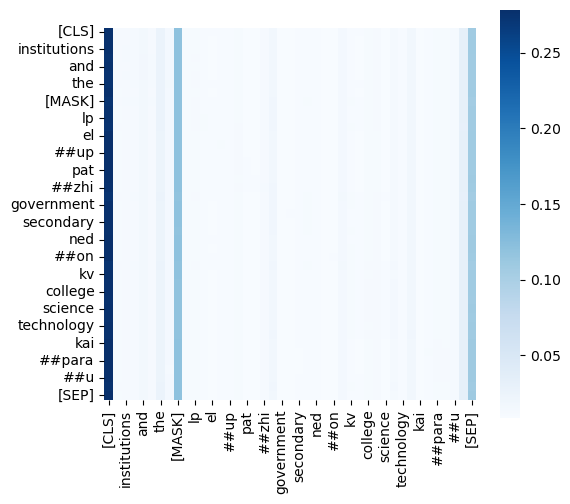

In [79]:
layer = -1
plt.figure(figsize=(6,6))
df = pd.DataFrame(joint_attentions[layer].cpu().detach().numpy(),columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Blues",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

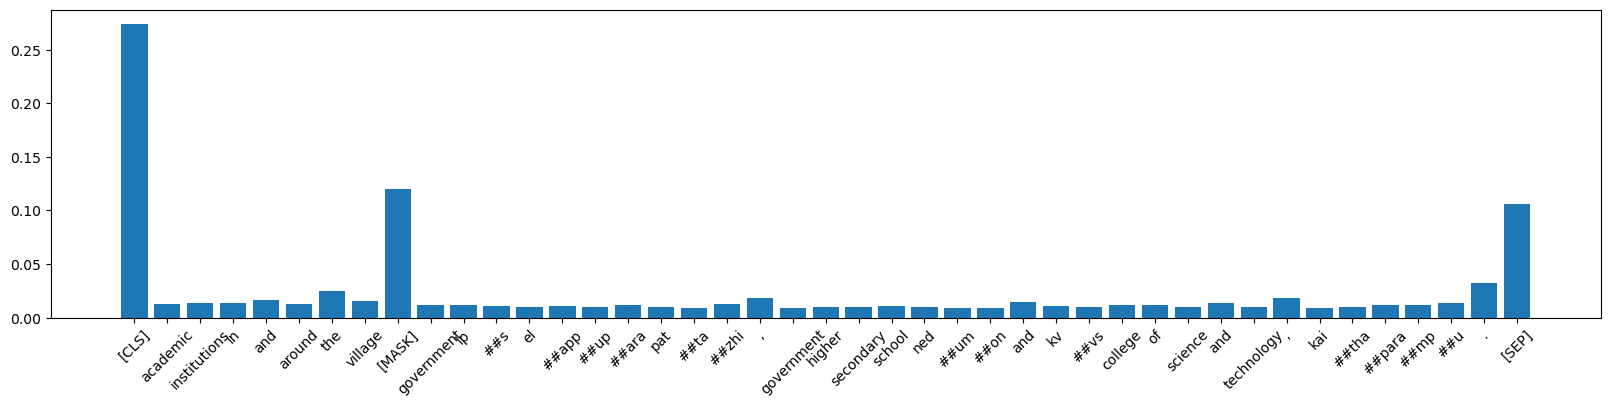

In [80]:
joint_attention_layer = -1
pos = target_idx
joint_attentions_mask = joint_attentions[joint_attention_layer][pos]
plot_histogram(joint_attentions_mask,tokenized_text)

### Attention rollout + |T(x_j)| (Kobayashi et al., 2021)

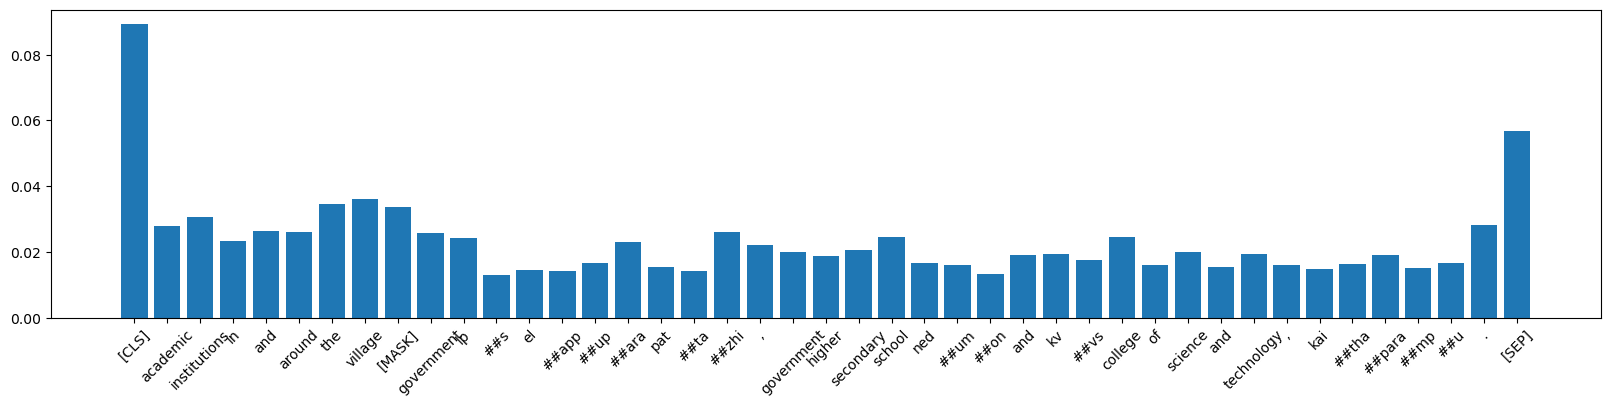

In [81]:
norms_mix = compute_joint_attention(normalized_model_norms)
joint_attention_layer = -1
pos = target_idx
norms_mix_mask = norms_mix[joint_attention_layer][pos]
plot_histogram(norms_mix_mask,tokenized_text)

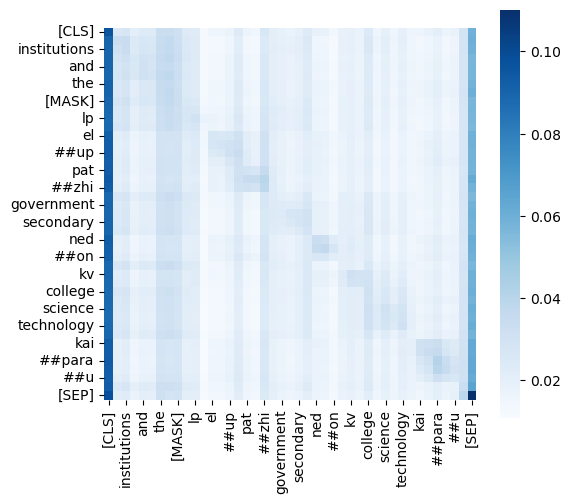

In [82]:
norms_mix = norms_mix.detach().cpu().numpy()
plt.figure(figsize=(6,6))
joint_attention_layer = -1
df = pd.DataFrame(norms_mix[joint_attention_layer],columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Blues",square=True)
plt.gcf().subplots_adjust(bottom=0.2)


### ALTI

torch.float32


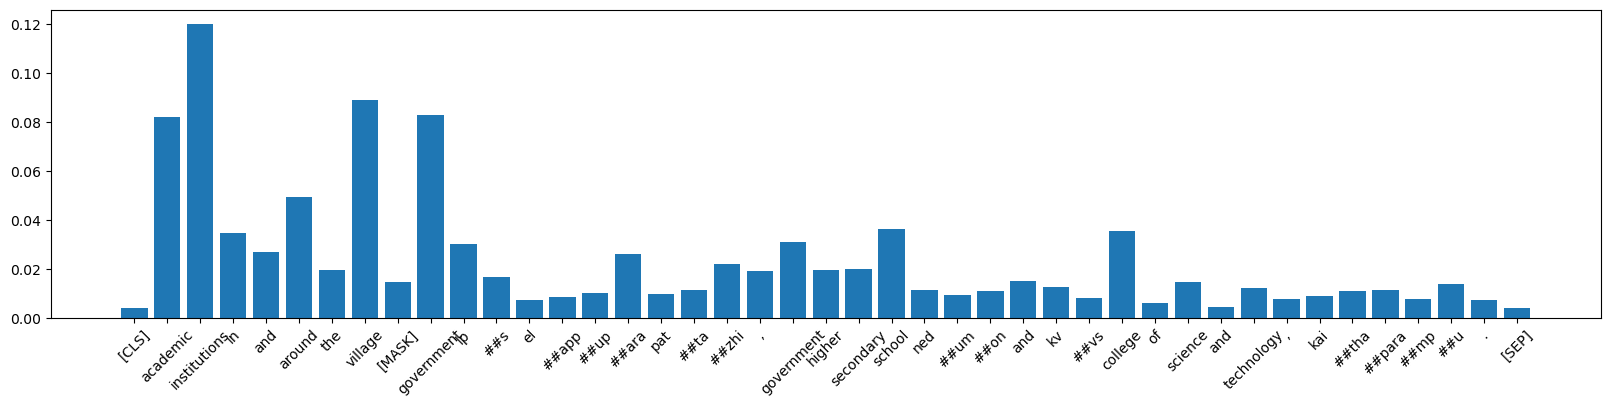

In [83]:
print(normalized_contributions.dtype)
contributions_mix = compute_joint_attention(normalized_contributions)
joint_attention_layer = -1
pos = target_idx
contributions_mix_mask = contributions_mix[joint_attention_layer][pos]
plot_histogram(contributions_mix_mask,tokenized_text)

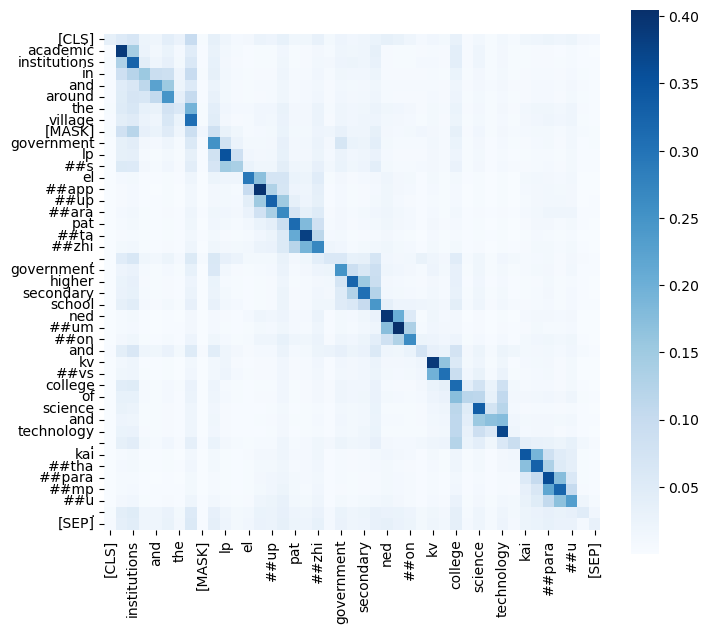

In [84]:
contributions_mix = contributions_mix.detach().cpu().numpy()
plt.figure(figsize=(8,8))

#joint_attention_normalized_layer = contributions_mix[joint_attention_layer] / joint_attentions[joint_attention_layer].sum(axis=-1)[...,None]
df = pd.DataFrame(contributions_mix[joint_attention_layer],columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Blues",square=True)#Reds,,center=0
plt.gcf().subplots_adjust(bottom=0.2)


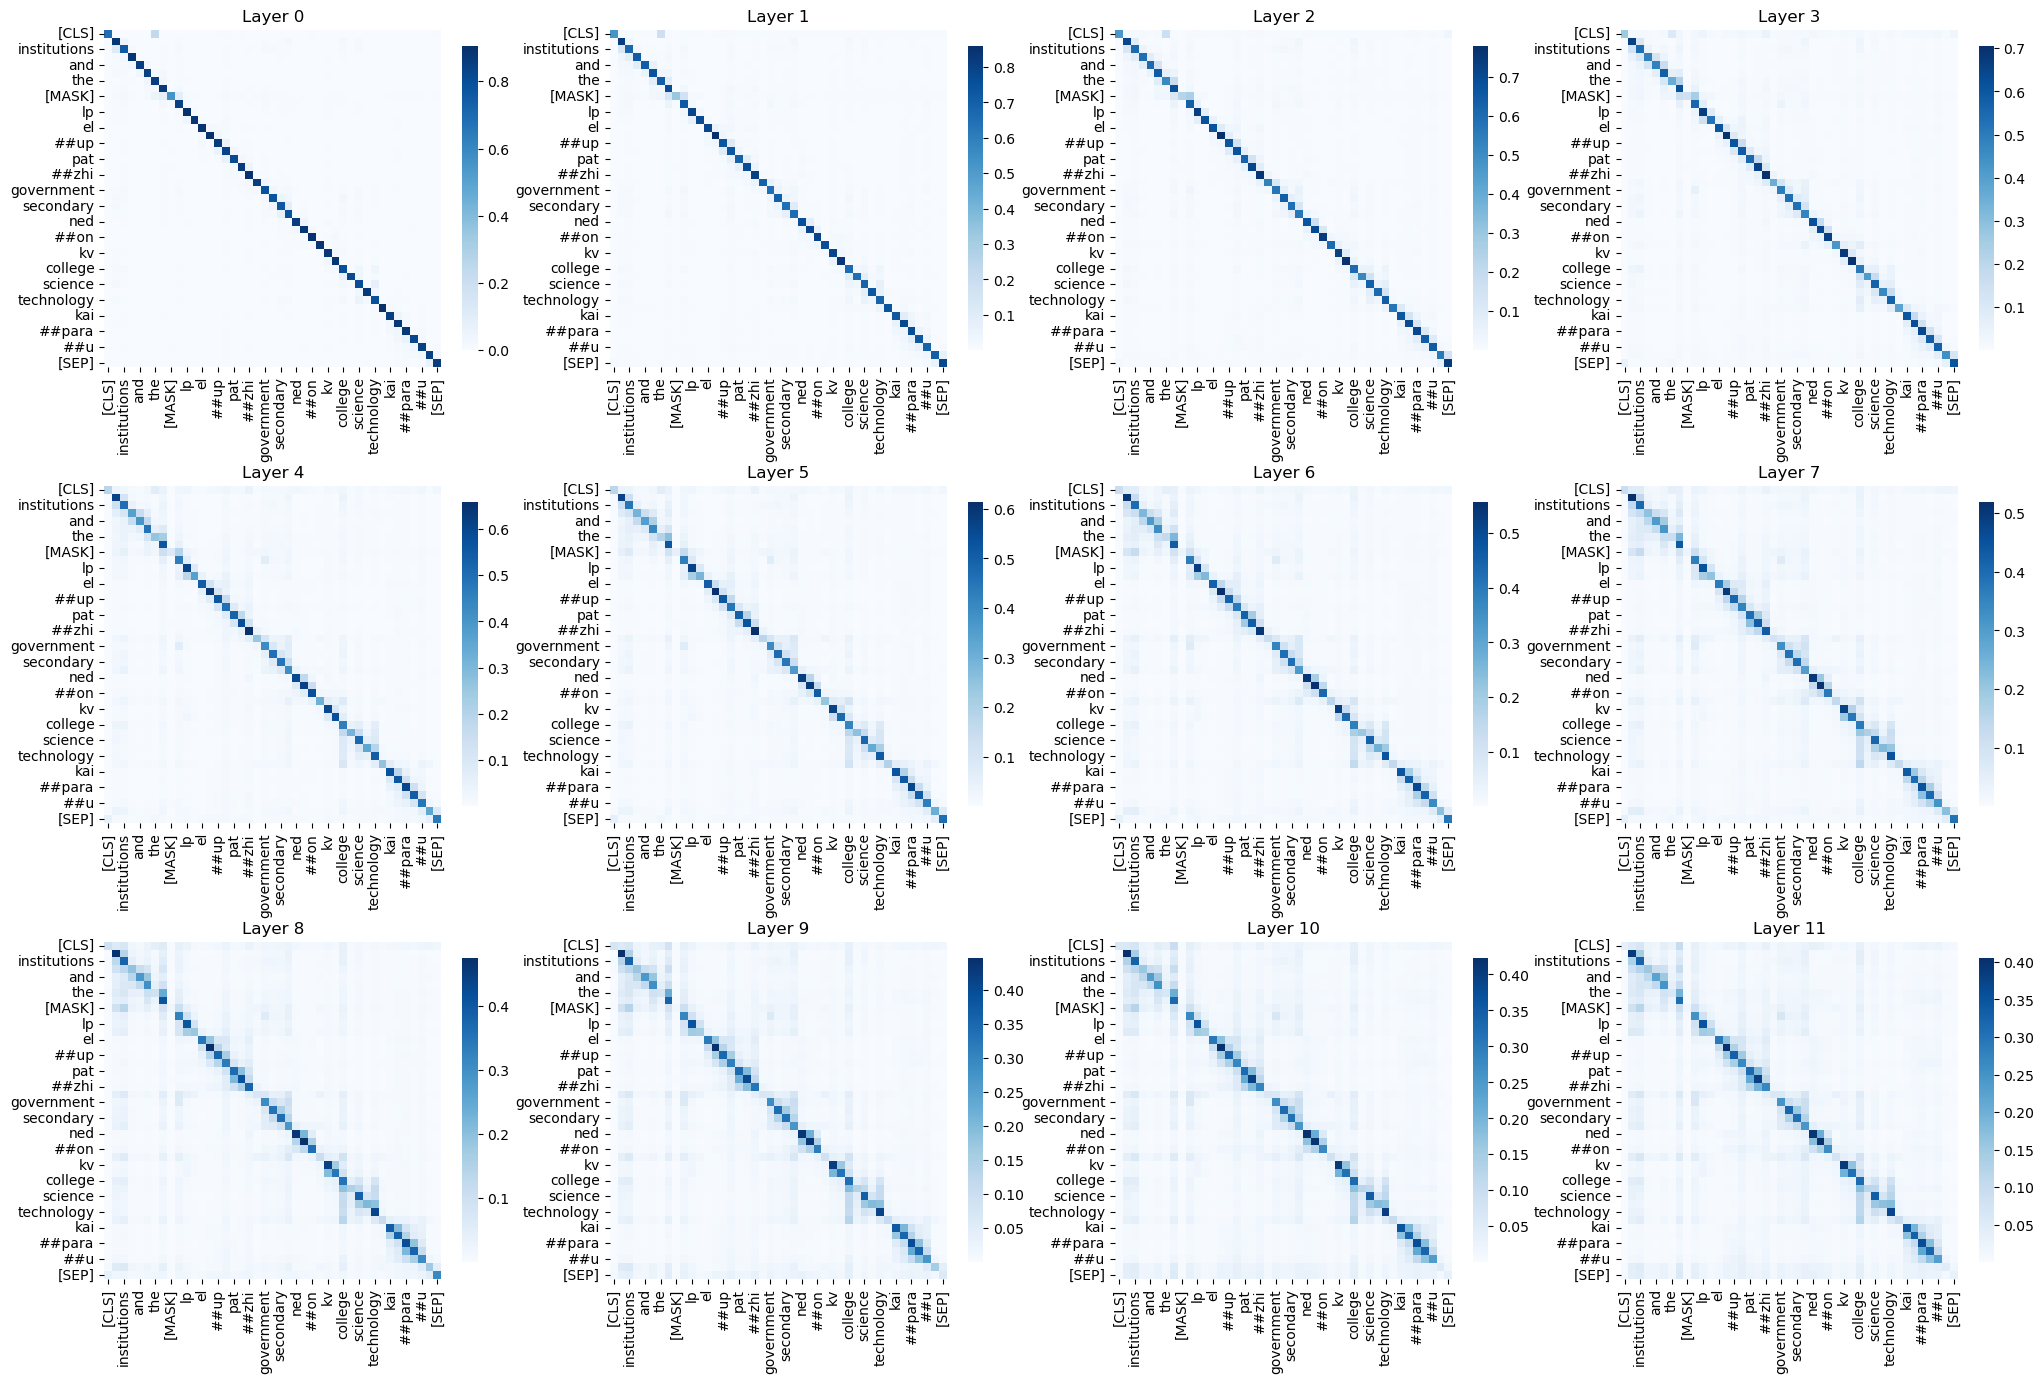

In [85]:
try:
    num_layers = model.config.num_hidden_layers
except:
    num_layers = model.config.n_layers

if num_layers == 12:
    fig, axs = plt.subplots(3, 4,figsize=(25,19),sharey=False)
    row = 4
    col = 4
elif num_layers == 6:
    fig, axs = plt.subplots(2, 3,figsize=(20,13),sharey=False)
    row = 3
    col = 3

for layer in range(0,num_layers):
    df = pd.DataFrame(contributions_mix[layer],columns=tokenized_text,index=tokenized_text)
    sns.heatmap(df,cmap="Blues",square=True,ax=axs[int(layer/row),layer%col],cbar_kws={'shrink': 0.8})
    axs[int(layer/row),layer%col].set_title('Layer ' + str(layer))
    axs[int(layer/row),layer%col].tick_params(axis='x', rotation=90)
    plt.gcf().subplots_adjust(bottom=0.2)

## Other attribution methods with Captum

In [86]:
bert_model_wrapper = LMModelWrapperCaptum(model)

grad_attributions = interpret_sentence_sv(bert_model_wrapper, tokenizer, sentence=text, method='grad', mask_pos=target_idx, label=pred_ind)
grad_input_attributions = interpret_sentence_sv(bert_model_wrapper, tokenizer, sentence=text, method='grad_input', mask_pos=target_idx, label=pred_ind)
grad_ig_attributions = interpret_sentence_sv(bert_model_wrapper, tokenizer, sentence=text, method='ig', mask_pos=target_idx, label=pred_ind)


In [87]:
# accumalate samples in this array for visualization purposes
vis_data_records_ig = []

def add_attributions_to_visualizer(attributions, tokens, label, vis_data_records):
    pred = 1
    attributions_min_max = normalize_attribution_visualization(attributions)
    attributions_min_max = attributions_min_max.cpu().detach().numpy()

    
    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions_min_max,
                            pred,
                            label,
                            label,
                            "label",
                            attributions_min_max.sum(),       
                            tokens[:len(attributions_min_max)],
                            0))
    return attributions_min_max

tokens = tokenizer.convert_ids_to_tokens(pt_batch["input_ids"][0].cpu().detach().numpy().tolist())
min_max_grad_attributions = add_attributions_to_visualizer(grad_attributions, tokens, pred_ind, vis_data_records_ig)
min_max_grad_input_attributions = add_attributions_to_visualizer(grad_input_attributions, tokens, pred_ind, vis_data_records_ig)
min_max_grad_ig_attributions = add_attributions_to_visualizer(grad_ig_attributions, tokens, pred_ind, vis_data_records_ig)
min_max_joint_attention_rollout_mask = add_attributions_to_visualizer(joint_attentions_mask, tokens, pred_ind, vis_data_records_ig)
min_max_norm_rollout_mask = add_attributions_to_visualizer(norms_mix_mask, tokens, pred_ind, vis_data_records_ig)
blankout_mask = add_attributions_to_visualizer(diffs, tokens, pred_ind, vis_data_records_ig)
min_max_contributions_mix_mask = add_attributions_to_visualizer(contributions_mix_mask, tokens, pred_ind, vis_data_records_ig)
visualization.visualize_text(vis_data_records_ig);